In [1]:
import seaborn as sns
sns.set()

In [2]:
from static_grader import grader

# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this miniproject, you build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.  Each of your models will be scored by comparing its accuracy to the accuracy of a reference model that we developed.  A score of 1 indicates that your model performs as well as the reference model; not that your accuracy is 100%!

You will be given both a training set and a test set.  Ground truth values are provided for the training set.  You should train your models on this set, and then make predictions for each of the test images.  These predictions will be submitted to the grader.

## A note on scoring

It **is** possible to score above 1 on these questions. This indicates that you've beaten our reference model&mdash;we compare our model's score on a test set to your score on a test set. See how high you can go!

## Downloading the data

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.  The following cell will download the data, in NumPy's `.npy` format.

In [3]:
!aws s3 sync s3://dataincubator-course/cifar10/ . --exclude 'valid*'

We can load in the data like so:

In [4]:
import numpy as np
import gzip

train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))
test_images = np.load(gzip.open('test_images.npy.gz', 'rb'))

In [7]:
train_labels[0:3]

array([6, 9, 9])

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

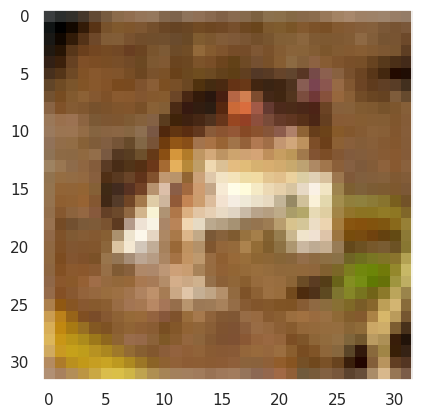

In [6]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [7]:
train_labels[0]

6

The human-readable names associated with this classes are

In [8]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
label_names[train_labels[0]]

'frog'

So we can see that the image above is a frog.  (Now you see it!)

In [10]:
train_labels[0]

array([[[0.04313726, 0.05490196, 0.09411765],
        [0.04705882, 0.05882353, 0.09411765],
        [0.03921569, 0.05098039, 0.08627451],
        ...,
        [0.03529412, 0.03921569, 0.05882353],
        [0.03137255, 0.03529412, 0.05490196],
        [0.03137255, 0.03529412, 0.05490196]],

       [[0.04313726, 0.05490196, 0.09019608],
        [0.03921569, 0.05098039, 0.08627451],
        [0.04313726, 0.05490196, 0.09019608],
        ...,
        [0.03137255, 0.03529412, 0.05490196],
        [0.02745098, 0.03137255, 0.05098039],
        [0.03137255, 0.03529412, 0.05490196]],

       [[0.04705882, 0.05882353, 0.09411765],
        [0.04313726, 0.05490196, 0.09019608],
        [0.04313726, 0.05490196, 0.09019608],
        ...,
        [0.03137255, 0.03529412, 0.05490196],
        [0.03137255, 0.03529412, 0.05490196],
        [0.03137255, 0.03529412, 0.05490196]],

       ...,

       [[0.972549  , 0.9529412 , 0.91764706],
        [0.92941177, 0.8980392 , 0.85882354],
        [0.8745098 , 0

# Questions

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric to determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

Build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that the intention here in our solution is that `images` will be a stack of images, while `base` is a single image.  Since the function is decorated with `tf.function` the computations within the function will be recorded in a computation graph and the output from this function will be a tensor.)

In [11]:
import tensorflow as tf

@tf.function
def delta_func(base, images):
    # Convert images to float32
    images = tf.cast(images, tf.float32)
    base = tf.cast(base, tf.float32)

    # Calculate differences in red, green, and blue channels
    delta_r = images[:, :, :, 0] - base[:, :, :, 0]
    delta_g = images[:, :, :, 1] - base[:, :, :, 1]
    delta_b = images[:, :, :, 2] - base[:, :, :, 2]

    # Calculate average red channel
    avg_r = (images[:, :, :, 0] + base[:, :, :, 0]) / 2.0

    # Calculate Δ𝐶 using the provided formula
    delta_c = tf.sqrt(2 * tf.square(delta_r) + 4 * tf.square(delta_g) + 3 * tf.square(delta_b) + avg_r * (tf.square(delta_r) - tf.square(delta_b)))

    return delta_c

@tf.function
def compute_distance(test_images, training_images):
    num_training_images = tf.shape(training_images)[0]  # Get the number of training images
    
    # Reshape and tile the base test image to match the number of training images
    base_test_image = test_images[0:1, :, :, :]
    tiled_base_test_image = tf.tile(base_test_image, [num_training_images, 1, 1, 1])
    
    delta = delta_func(tiled_base_test_image, training_images)  # Compute delta for all training images
    
    # Compute the average delta value for each training image
    avg_deltas = tf.reduce_mean(delta, axis=[1, 2])  # Reduce along dimensions 1 and 2
    
    return avg_deltas

import tensorflow as tf

@tf.function
def delta_func(images, base):
    ...

As stated, for two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

Using `delta_func` compute the distance between the first test image and all of the training images.

**Checkpoint:** The mean value of the distances is 1.159, and the standard deviation of the distances is 0.182.

In [12]:
distances = compute_distance(test_images, train_images)

In [ ]:
deltas = ...

From these, find the 100 closest images from the training set to this first test image.  (Note that `numpy.argsort` might help here.)  Submit a list of the indices of these images to the grader.

In [13]:
# Find the indices that would sort the distances in ascending order
sorted_indices = np.argsort(distances)

# Get the indices of the 100 closest images
top_100_indices = sorted_indices[:100]

# Now you can use these indices to retrieve the actual training images
closest_images = train_images[top_100_indices]

In [16]:
top_100_indices

array([27912, 23437, 47732, 25053, 29251,  3616, 43445,  5555, 46911,
       16269, 45450, 47893, 27833, 41078,  6385, 32788,  2108, 44366,
       40857, 18619, 32596, 43840, 42187,  7982, 47629, 14298, 29521,
       15860, 48219, 25953, 24522,  1363, 32891, 18702, 19759, 16247,
        5859,  3303, 37982,  5463,  9738,  8448,  4881, 14185, 18347,
       35163, 13960, 39700,  7837, 36899, 31793, 11317, 29615, 10413,
       45178, 16021, 40089,  6224, 42620, 14932, 27543, 18868, 46440,
       17882, 44700, 11784, 24729, 37317, 45209, 10709, 17501, 10440,
       46378, 32430, 15659, 21665, 25680, 30766, 46671, 43551, 32145,
       20364, 11465, 40643, 12229, 23235,  6878, 36196, 33346,  2986,
       22061, 16130, 43791,  8380, 17921, 45047,  1582, 32047,  3060,
        1015])

In [17]:
indices = [43234]*100

grader.score('tf__perceptual_delta', top_100_indices)

Your score: 1.0000


**Extension:** What does this suggest about the proper class for this image?

> **Aside:** Essentially, we've started to implement a $k$-nearest neighbors algorithm, using this perceptual distance as our metric.  If we ran the difference between all of the test images and each of the training images, we could make a prediction from the nearest images for each.  Give it a try, if you're interested, but this miniproject is going to go in another direction.

## Softmax model

We could use this delta function to measure distances from images with known classes, but that's not really the Deep Learning Way (TM).  Instead, we'll let neural networks figure out how to connect pixel values to classes.

We'll start with something that barely qualifies as a neural network: a softmax classifier.  This has no hidden layers; instead a single dense layer takes $32\times32\times3$ inputs and produces 10 outputs, one for each class.  It should use a softmax activation and a `CategoricalCrossentropy` loss function.

Build such a model and train it on the training data.  Then use this model to make a prediction on each of the 10,000 test images.

**Hints:**
- The labels are given as integers, but softmax expects one-hot encoding of the labels.  The `tf.one_hot` function can do the conversion.
- TensorFlow's `.predict` method will return probabilities for each image being in each class, but the grader wants only the class prediction.  You may find the `np.argmax` function helpful in determining the class with the highest probability.

In [5]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Load your training data and labels (replace these with your actual data)
x_train = train_images
y_train = train_labels


# Preprocess labels with one-hot encoding
num_classes = 10
y_train_one_hot = tf.one_hot(y_train, num_classes).numpy()

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_one_hot, test_size=0.2, random_state=42)

# Preprocess labels with one-hot encoding
y_train_one_hot = tf.one_hot(y_train, num_classes).numpy()
y_test_one_hot = tf.one_hot(y_test, num_classes).numpy()

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),  # Flatten the input images
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use softmax cross-entropy loss
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/5
1125/1125 [==============================] - 3s 2ms/step - loss: 1.9901 - accuracy: 0.3089 - val_loss: 1.9945 - val_accuracy: 0.3075
Epoch 2/5
1125/1125 [==============================] - 2s 2ms/step - loss: 1.8960 - accuracy: 0.3478 - val_loss: 1.8862 - val_accuracy: 0.3620
Epoch 3/5
1125/1125 [==============================] - 2s 2ms/step - loss: 1.8642 - accuracy: 0.3582 - val_loss: 1.9145 - val_accuracy: 0.3313
Epoch 4/5
1125/1125 [==============================] - 2s 2ms/step - loss: 1.8456 - accuracy: 0.3650 - val_loss: 1.8086 - val_accuracy: 0.3913
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 1.8050 - accuracy: 0.3768


In [6]:
# Load your test data (replace this with your actual test data)
test_data = test_images

# Make predictions on the test data
predictions = model.predict(test_data)

# The 'predictions' array will contain the predicted class probabilities for each image
# You can get the predicted classes by finding the index of the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

313/313 [==============================] - 0s 1ms/step


In [7]:
#predicted_classes = [0]*len(test_images)

grader.score('tf__softmax', predicted_classes)

Your score: 1.1164


## Fully-connected model

Now, add a hidden layer to this network.  Train this network on the pixel values, and once again use it to predict the most likely class for each of the test images.

**Hints:**
- We found that adding more layers didn't help too much.
- Watch out for overfitting.  Dropout can help with this.
- The reference solution achieves an accuracy of about 44% on a training set and 41% on a test set.

In [5]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Load your training data and labels (replace these with your actual data)
x_train = train_images
y_train = train_labels


# Preprocess labels with one-hot encoding
num_classes = 10
y_train_one_hot = tf.one_hot(y_train, num_classes).numpy()

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_one_hot, test_size=0.2, random_state=42)

# Preprocess labels with one-hot encoding
y_train_one_hot = tf.one_hot(y_train, num_classes).numpy()
y_test_one_hot = tf.one_hot(y_test, num_classes).numpy()

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),  # Flatten the input images
    tf.keras.layers.Dense(128, activation='relu'),    # Hidden layer with ReLU activation
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use softmax cross-entropy loss
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/5
1125/1125 [==============================] - 5s 4ms/step - loss: 1.9381 - accuracy: 0.3018 - val_loss: 1.8739 - val_accuracy: 0.3195
Epoch 2/5
1125/1125 [==============================] - 4s 4ms/step - loss: 1.7969 - accuracy: 0.3594 - val_loss: 1.8145 - val_accuracy: 0.3528
Epoch 3/5
1125/1125 [==============================] - 4s 4ms/step - loss: 1.7360 - accuracy: 0.3818 - val_loss: 1.7179 - val_accuracy: 0.3775
Epoch 4/5
1125/1125 [==============================] - 4s 4ms/step - loss: 1.6956 - accuracy: 0.3935 - val_loss: 1.7033 - val_accuracy: 0.3840
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 1.6646 - accuracy: 0.3967


In [7]:
# Load your test data (replace this with your actual test data)
test_data = test_images

# Make predictions on the test data
predictions = model.predict(test_data)

# The 'predictions' array will contain the predicted class probabilities for each image
# You can get the predicted classes by finding the index of the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

313/313 [==============================] - 0s 1ms/step


In [8]:
#predicted_classes = [0]*len(test_images)

grader.score('tf__fully_connected', predicted_classes)

Your score: 1.0958


## Convolutional model

Convolutional neural networks have had a lot of success in image classification.  Build a neural network with convolutional layers to improve the performance.

**Hints:**
- The reference solution uses two convolutional layers and two fully-connected layers.
- We found success with the `AdamOptimizer`.
- The reference solution achieves an accuracy of roughly 80% on a training set and 70% on a test set.

In [15]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Load your training data and labels (replace these with your actual data)
x_train = train_images
y_train = train_labels


# Preprocess labels with one-hot encoding
num_classes = 10
y_train_one_hot = tf.one_hot(y_train, num_classes).numpy()

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_one_hot, test_size=0.2, random_state=42)

# Preprocess labels with one-hot encoding
y_train_one_hot = tf.one_hot(y_train, num_classes).numpy()
y_test_one_hot = tf.one_hot(y_test, num_classes).numpy()

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # 1st Convolutional layer
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='same'), # MaxPooling layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), # 2nd Convolutional layer
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='same'), # MaxPooling layer
    tf.keras.layers.Flatten(), # Flatten the output from the convolutional layers
    tf.keras.layers.Dense(128, activation='relu'), # Hidden layer with ReLU activation
    tf.keras.layers.Dense(num_classes, activation='softmax') # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use softmax cross-entropy loss
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1,validation_data=(x_test,y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/5
1250/1250 [==============================] - 25s 20ms/step - loss: 1.4387 - accuracy: 0.4809 - val_loss: 1.2186 - val_accuracy: 0.5709
Epoch 2/5
1250/1250 [==============================] - 24s 19ms/step - loss: 1.0583 - accuracy: 0.6294 - val_loss: 1.0268 - val_accuracy: 0.6400
Epoch 3/5
1250/1250 [==============================] - 24s 19ms/step - loss: 0.8976 - accuracy: 0.6844 - val_loss: 0.9870 - val_accuracy: 0.6558
Epoch 4/5
1250/1250 [==============================] - 24s 19ms/step - loss: 0.7887 - accuracy: 0.7243 - val_loss: 0.9074 - val_accuracy: 0.6852
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.8651 - accuracy: 0.6995


In [16]:
# Load your test data (replace this with your actual test data)
test_data = test_images

# Make predictions on the test data
predictions = model.predict(test_data)

# The 'predictions' array will contain the predicted class probabilities for each image
# You can get the predicted classes by finding the index of the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

313/313 [==============================] - 2s 5ms/step


In [17]:
grader.score('tf__convolutional', predicted_classes)

Your score: 0.9525


## Transfer learning

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images.  Luckily, we have already discussed such a network: the Inception network used in the Deep Dream notebook.

The following cell will load the model, omitting its classification layer (since we're not interested in classifying `ImageNet` images).

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

In a transfer learning setup, we will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network.  There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

However, this can be a bit wasteful when multiple epochs of training will be undertaken since we recalculate the latent vectors on every training step.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions.  We recommend this approach for this miniproject.

Images should be fed to the `inception` network and then vectorized (you might want to refer to the `TF_DeepDream.ipynb` notebook).

We've loaded the `inception` network with its native image shape: $299 \times 299$.  This implies that we need to upscale our images from $32\times32$ to $299\times299$.  There are a number of ways to do this; the reference solution uses `tf.image.resize` with bilinear interpolation.  (More sophisticated resizing methods produce better results, but will take significantly longer!)

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily.  You also probably want to save those latent vectors to disk, to avoid the need to repeat this calculation later.

**Hints:**
- Be sure to batch this calculation; resizing all 50,000 images at once will cause memory errors.
- The latent vector calculation took us between 30 minutes and 2 hours on a single machine.  You might consider distributing the calculation.
- The latent vectors for the first 10 images have an average of 1983 non-zero values and an overall average value of 0.319.

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions.

**Hints:**
- The reference solution has three layers.
- The reference solution achieves a training accuracy of 87% and a test accuracy of 85%.

In [5]:
import tensorflow as tf
import numpy as np

# Load the InceptionV3 model without the classification layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model(inputs=inception.input, outputs=inception.layers[-2].output)

# Load and preprocess your original images (assuming you have a list of images)
original_images = train_images[40000:]  # List of original images

# Batch size for processing images in batches
batch_size = 300

# Create a list to store latent vectors
latent_vectors = []

# Process images in batches
for i in range(0, len(original_images), batch_size):
    batch_images = original_images[i:i + batch_size]

    # Preprocess and compute latent vectors for the batch
    batch_latent_vectors = []
    for image in batch_images:
        resized_image = tf.image.resize(image, (299, 299), method=tf.image.ResizeMethod.BILINEAR)
        preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(resized_image)
        batch_latent_vectors.append(preprocessed_image)
    
    # Convert the batch of images to a tensor
    batch_latent_vectors = tf.stack(batch_latent_vectors)

    # Obtain latent vectors for the batch
    batch_latent_vectors = inception.predict(batch_latent_vectors)
    latent_vectors.append(batch_latent_vectors)

# Concatenate all the batched latent vectors
latent_vectors = tf.concat(latent_vectors, axis=0)

# Convert latent vectors to a NumPy array
latent_vectors_array = latent_vectors.numpy()

# Save latent vectors to disk using NumPy's save function
np.save('latent_vectors5.npy', latent_vectors_array)


4/4 [==============================] - 6s 1s/step


In [5]:
# List of filenames for saved latent vector arrays
latent_vector_filenames = ['latent_vectors1.npy', 'latent_vectors2.npy', 'latent_vectors3.npy', 'latent_vectors4.npy', 'latent_vectors5.npy']

# Load each saved array and store them in a list
loaded_arrays = []
for filename in latent_vector_filenames:
    loaded_array = np.load(filename)
    loaded_arrays.append(loaded_array)

# Concatenate the loaded arrays along axis 0 (row-wise)
latent_vectors = np.concatenate(loaded_arrays, axis=0)

In [6]:
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

num_classes = 10
# Load your labels (assuming you have a list of labels corresponding to the original images)
labels = train_labels

# Split the data into training and validation sets using train_test_split
train_latent_vectors, val_latent_vectors, train_labels, val_labels = train_test_split(
    latent_vectors, labels, test_size=0.2, random_state=42)

# Define your prediction network
prediction_model = models.Sequential([
    layers.Input(shape=(latent_vectors.shape[1],)),
    layers.Reshape((32, 32, 2)),  # Reshape latent vectors to match image dimensions

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
prediction_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Train the prediction model
history = prediction_model.fit(train_latent_vectors, train_labels,
                               epochs=40,
                               batch_size=200,
                               validation_data=(val_latent_vectors, val_labels))

# Evaluate the model
test_loss, test_accuracy = prediction_model.evaluate(val_latent_vectors, val_labels)
print("Test accuracy:", test_accuracy)


Epoch 1/40
200/200 [==============================] - 12s 54ms/step - loss: 2.3028 - accuracy: 0.1053 - val_loss: 2.2996 - val_accuracy: 0.1040
Epoch 2/40
200/200 [==============================] - 11s 53ms/step - loss: 2.2231 - accuracy: 0.1498 - val_loss: 2.1439 - val_accuracy: 0.1809
Epoch 3/40
200/200 [==============================] - 11s 53ms/step - loss: 2.1300 - accuracy: 0.1855 - val_loss: 2.0759 - val_accuracy: 0.2124
Epoch 4/40
200/200 [==============================] - 11s 53ms/step - loss: 2.0551 - accuracy: 0.2194 - val_loss: 1.9415 - val_accuracy: 0.2690
Epoch 5/40
200/200 [==============================] - 11s 53ms/step - loss: 1.9579 - accuracy: 0.2545 - val_loss: 1.8704 - val_accuracy: 0.2906
Epoch 6/40
200/200 [==============================] - 11s 54ms/step - loss: 1.8961 - accuracy: 0.2802 - val_loss: 1.8514 - val_accuracy: 0.2987
Epoch 7/40
200/200 [==============================] - 11s 54ms/step - loss: 1.8711 - accuracy: 0.2907 - val_loss: 1.7905 - val_accuracy:

In [7]:
# Train the prediction model
history = prediction_model.fit(train_latent_vectors, train_labels,
                               epochs=50,
                               batch_size=400,
                               validation_data=(val_latent_vectors, val_labels))

# Evaluate the model
test_loss, test_accuracy = prediction_model.evaluate(val_latent_vectors, val_labels)

Epoch 1/50
100/100 [==============================] - 11s 100ms/step - loss: 1.5717 - accuracy: 0.4365 - val_loss: 1.4824 - val_accuracy: 0.4662
Epoch 2/50
100/100 [==============================] - 10s 101ms/step - loss: 1.5592 - accuracy: 0.4395 - val_loss: 1.5253 - val_accuracy: 0.4539
Epoch 3/50
100/100 [==============================] - 10s 99ms/step - loss: 1.5563 - accuracy: 0.4414 - val_loss: 1.4814 - val_accuracy: 0.4619
Epoch 4/50
100/100 [==============================] - 10s 100ms/step - loss: 1.5598 - accuracy: 0.4399 - val_loss: 1.4936 - val_accuracy: 0.4553
Epoch 5/50
100/100 [==============================] - 10s 99ms/step - loss: 1.5491 - accuracy: 0.4457 - val_loss: 1.4744 - val_accuracy: 0.4677
Epoch 6/50
100/100 [==============================] - 10s 100ms/step - loss: 1.5557 - accuracy: 0.4422 - val_loss: 1.5070 - val_accuracy: 0.4592
Epoch 7/50
100/100 [==============================] - 10s 100ms/step - loss: 1.5518 - accuracy: 0.4444 - val_loss: 1.4974 - val_accu

In [8]:
# Load your test data
test_data = val_latent_vectors

# Make predictions on the test data
predictions = prediction_model.predict(test_data)

# The 'predictions' array will contain the predicted class probabilities for each image
# You can get the predicted classes by finding the index of the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

313/313 [==============================] - 1s 4ms/step


In [8]:
import gc
i=0

while (i != 20):

    test_images_resized = [tf.image.resize(
                            test_images[(i)*500:(i+1)*500],
                            (299,299),
                            method = 'bilinear')]
    
    bravo = inception.predict(test_images_resized)
    np.save(f'test_image_batch_{i}',bravo)
    
    i = i + 1
    display(i)
    gc.collect()

16/16 [==============================] - 26s 2s/step


1

16/16 [==============================] - 26s 2s/step


2

16/16 [==============================] - 26s 2s/step


3

16/16 [==============================] - 26s 2s/step


4

16/16 [==============================] - 26s 2s/step


5

16/16 [==============================] - 26s 2s/step


6

16/16 [==============================] - 26s 2s/step


7

16/16 [==============================] - 26s 2s/step


8

16/16 [==============================] - 26s 2s/step


9

16/16 [==============================] - 26s 2s/step


10

16/16 [==============================] - 26s 2s/step


11

16/16 [==============================] - 26s 2s/step


12

16/16 [==============================] - 26s 2s/step


13

16/16 [==============================] - 26s 2s/step


14

16/16 [==============================] - 26s 2s/step


15

16/16 [==============================] - 26s 2s/step


16

16/16 [==============================] - 26s 2s/step


17

16/16 [==============================] - 26s 2s/step


18

16/16 [==============================] - 26s 2s/step


19

16/16 [==============================] - 26s 2s/step


20

In [ ]:
i=0

while (i != 100):

    train_images_resized = [tf.image.resize(
                            train_images[(i)*500:(i+1)*500],
                            (299,299),
                            method = 'bilinear')]
    
    bravo = inception.predict(train_images_resized)
    np.save(f'train_image_batch_{i}',bravo)
    
    i = i + 1
    display(i)
    gc.collect()

In [6]:
from tensorflow.keras.utils import to_categorical as one_hot
train_labels_onehot = one_hot(train_labels, num_classes=10)

new_model = tf.keras.models.Sequential()
new_model.add(tf.keras.layers.Dense(1024,activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.3))
new_model.add(tf.keras.layers.Dense(1024,activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.3))
new_model.add(tf.keras.layers.Dense(10,activation='softmax'))

new_model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(),
                 metrics=['accuracy'])

load4train = np.load('train_image_batch_0.npy')

for i in range(1,100):
    load_next = np.load(f'train_image_batch_{i}.npy')
    load4train = np.concatenate((load4train,load_next), axis=0)
    
load4test = np.load('test_image_batch_0.npy')

for i in range(1,20):
    load_next_test = np.load(f'test_image_batch_{i}.npy')
    load4test = np.concatenate((load4test,load_next_test), axis=0)

In [7]:
from sklearn.model_selection import train_test_split

# Split the labels into training and testing sets
train_labels, test_labels = train_test_split(train_labels, test_size=0.2, random_state=42)

test_labels_onehot = one_hot(test_labels, num_classes=10)

In [12]:
print("load4train shape:", load4train.shape)
print("train_labels_onehot shape:", train_labels_onehot.shape)
print("load4test shape:", load4test.shape)
print("test_labels shape:", test_labels.shape)

load4train shape: (50000, 2048)
train_labels_onehot shape: (50000, 10)
load4test shape: (10000, 2048)
test_labels shape: (10000, 10)


In [17]:
load4test.shape

(10000, 2048)

In [8]:
# One-hot encode validation labels
test_labels_onehot = one_hot(test_labels, num_classes=10)  # Use the same num_classes as for training

# Train the prediction model
new_model.fit(load4train, train_labels_onehot,
              epochs=20,
              batch_size=200,
              validation_data=(load4test, test_labels_onehot))  # Use test_labels_onehot here

# Evaluate the model
test_loss, test_accuracy = new_model.evaluate(load4test, test_labels_onehot)

Epoch 1/20
250/250 [==============================] - 7s 27ms/step - loss: 1.3310 - accuracy: 0.5727 - val_loss: 4.1577 - val_accuracy: 0.0944
Epoch 2/20
250/250 [==============================] - 6s 26ms/step - loss: 0.7988 - accuracy: 0.7317 - val_loss: 5.0293 - val_accuracy: 0.0952
Epoch 3/20
250/250 [==============================] - 6s 26ms/step - loss: 0.6953 - accuracy: 0.7651 - val_loss: 5.4287 - val_accuracy: 0.0959
Epoch 4/20
250/250 [==============================] - 6s 26ms/step - loss: 0.6452 - accuracy: 0.7810 - val_loss: 5.6897 - val_accuracy: 0.0956
Epoch 5/20
250/250 [==============================] - 6s 26ms/step - loss: 0.6121 - accuracy: 0.7904 - val_loss: 5.8256 - val_accuracy: 0.0963
Epoch 6/20
250/250 [==============================] - 6s 26ms/step - loss: 0.5880 - accuracy: 0.7994 - val_loss: 5.9490 - val_accuracy: 0.0953
Epoch 7/20
250/250 [==============================] - 6s 25ms/step - loss: 0.5671 - accuracy: 0.8052 - val_loss: 6.0882 - val_accuracy: 0.0954

In [14]:
# Make predictions on the test data
predictions = new_model.predict([load4test])
submitter=[]
for prediction in predictions:
    submitter.append(np.argmax(prediction))

# The 'predictions' array will contain the predicted class probabilities for each image
# You can get the predicted classes by finding the index of the maximum probability
#predicted_classes = np.argmax(predictions, axis=1)
submitter

313/313 [==============================] - 1s 3ms/step


In [15]:
#predicted_classes = [0]*len(test_images)

grader.score('tf__transfer_learning', submitter)

Your score: 1.0045


*Copyright &copy; 2023 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*